# becquerel fitting example

In [1]:
import becquerel as bq
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.facecolor'] = 'white'

np.random.seed(0)

Read an example spectrum into a Spectrum object

In [2]:
spec1 = bq.Spectrum.from_file('../tests/samples/digibase_5min_30_1.spe')

SpeFile: Reading file ../tests/samples/digibase_5min_30_1.spe


//anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/jvavrek/becquerel/becquerel/parsers/spectrum_file.py:136: SpectrumFileParsingWarning: Spectrum will be initated without an energy calibration;invalid calibration, energies not monotonically increasing.
  SpectrumFileParsingWarning)


Plot the entire spectrum and the ROI we want to fit

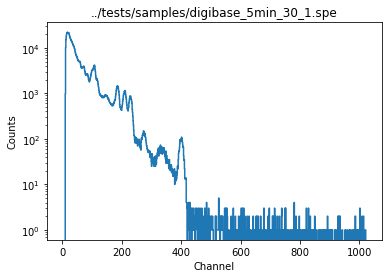

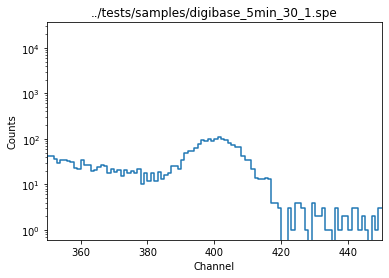

In [3]:
spec1.plot(yscale='log')
plt.show()

spec1.plot(yscale='log', xlim=(350, 450))
plt.show()

Let's first try a Gaussian peak shape and a simple linear background

In [4]:
model = (bq.fitting.GaussModel(prefix='gauss0_') + bq.fitting.LineModel(prefix='linear_'))

//anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Pass our model and data to a Fitter object, then perform the fit

In [5]:
fitter = bq.Fitter(
    model,
    x=spec1.bin_indices,
    y=spec1.counts_vals,
    y_unc=spec1.counts_uncs,
    roi=(350, 450)
)

fitter.fit()

`custom_plot()` lets us see the fit result and diagnostics simultaneously

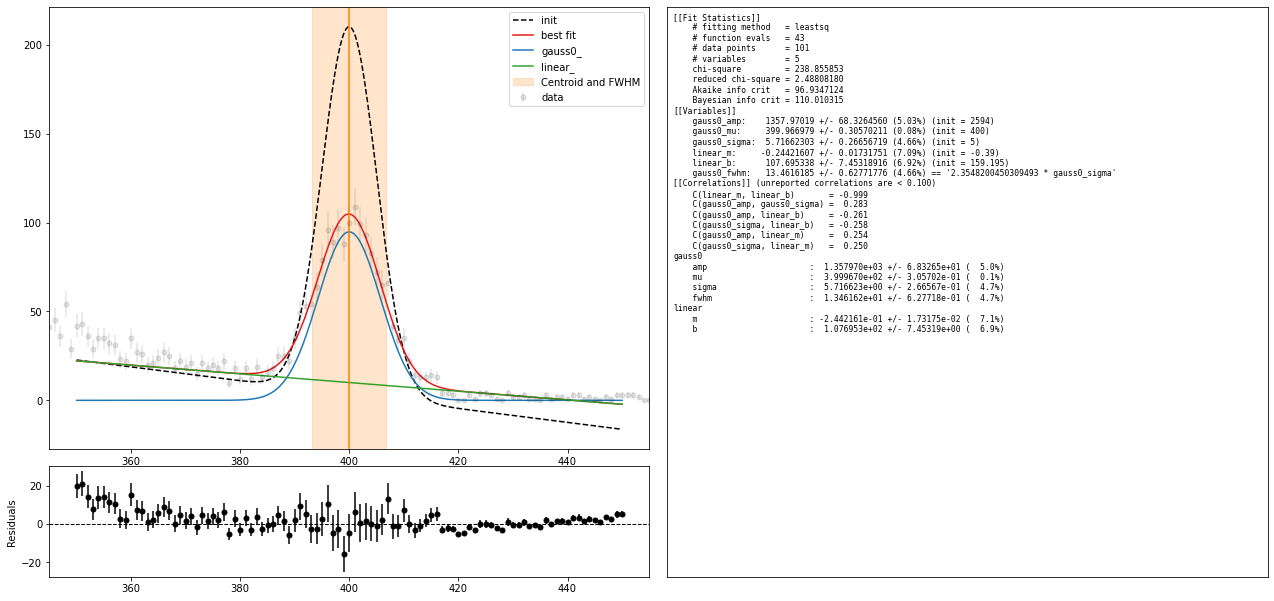

In [6]:
fitter.custom_plot()
plt.show()

It looks like there's still a trend in the residuals. Let's try an exponential background model instead of linear.
Note we can pass a list of string model names to the Fitter.

In [7]:
fitter = bq.Fitter(
    ['gauss', 'exp'],
    x=spec1.bin_indices,
    y=spec1.counts_vals,
    y_unc=spec1.counts_uncs,
    roi=(350, 450)
)
fitter.fit()

//anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


We can also specify that we want to plot residuals relative to the bin error (`residual_type=sigma`) or relative to the model (`residual_type=rel`) instead of absolute residuals (`residual_type=abs`, default).

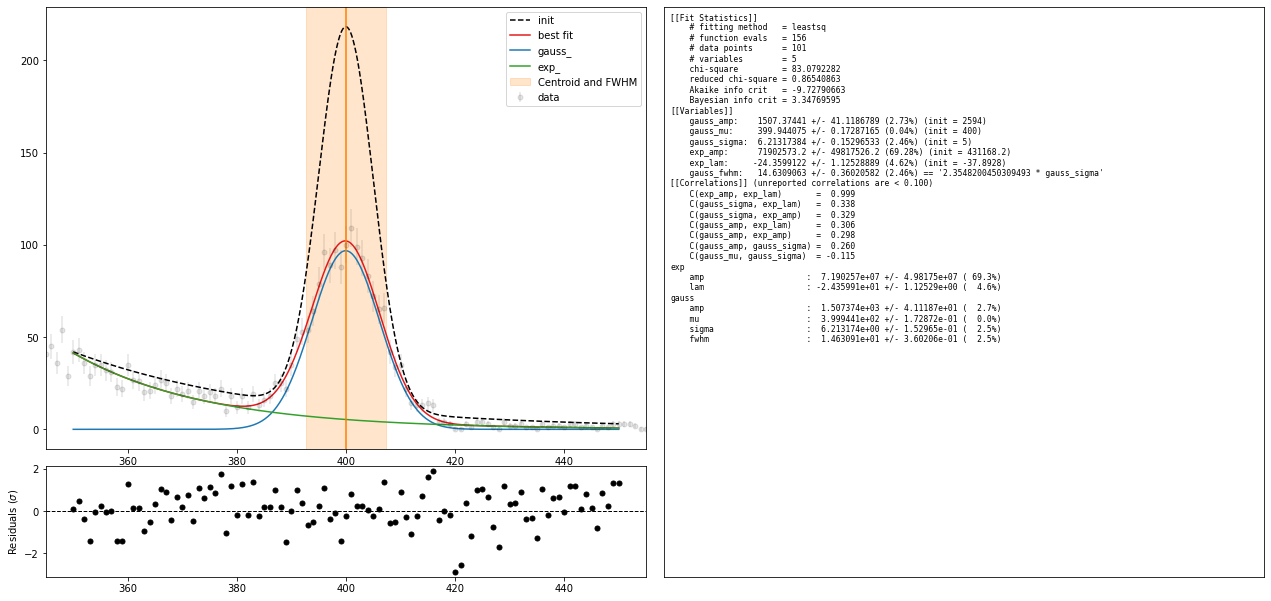

In [8]:
fitter.custom_plot(residual_type='sigma')
plt.show()

The normalized residuals help show that the exponential model fits fairly well---nearly all residuals are within $\pm2\sigma$, and there is no obvious trend.